<a href="https://colab.research.google.com/github/geopan2000/Loan-Approval-Prediction/blob/main/LoanApprovalPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [245]:
# Clone the GitHub repository
!git clone https://github.com/geopan2000/Loan-Approval-Prediction.git

# Change directory to the cloned repository
%cd Loan-Approval-Prediction

Cloning into 'Loan-Approval-Prediction'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 43 (delta 18), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 2.08 MiB | 5.49 MiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction/Loan-Approval-Prediction


In [246]:
import pandas as pd
import numpy as np
import xgboost as xgb

!pip install scikit-optimize
!pip install shap
from skopt import BayesSearchCV
from skopt.space import Real, Integer

from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from google.colab import files

In [247]:
train_set = pd.read_csv('/content/Loan-Approval-Prediction/data/train.csv') # Load train set
test_set = pd.read_csv('/content/Loan-Approval-Prediction/data/test.csv') #Load test set

In [248]:
print(train_set.isna().sum()) #inspect train set for possible missing values
print(test_set.isna().sum()) #inspect test set for possible missing values

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [249]:
print(train_set.dtypes) #inspect data types

id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object


In [250]:
print('The size of the train set is:', train_set.shape)
print('The size of the test set is:', test_set.shape) # the target variable is missing from the set

The size of the train set is: (58645, 13)
The size of the test set is: (39098, 12)


**Inspect which features are object type and what are the differnet values inside them**

In [251]:
print(train_set.info())
print(train_set['person_home_ownership'].value_counts())
print(train_set['loan_intent'].value_counts())
print(train_set['loan_grade'].value_counts())
print(train_set['cb_person_default_on_file'].value_counts())
print(train_set['loan_status'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

**Feature Engineering**

In [252]:
train_set['cb_person_default_on_file'].map({'Y': 1, 'N': 0})
train_set['loan_grade'].map({'A': 0.1, 'B': 0.2, 'C': 0.4, 'D': 0.5, 'E': 0.6, 'F': 0.8, 'G': 1})
train_set = pd.get_dummies(train_set, columns=['person_home_ownership', 'loan_intent'])
train_set.drop(['id','loan_grade','cb_person_default_on_file'], axis=1, inplace=True)

test_id=test_set['id'] # coljumn needed for final submission
test_set['cb_person_default_on_file'].map({'Y': 1, 'N': 0})
test_set['loan_grade'].map({'A': 0.1, 'B': 0.2, 'C': 0.4, 'D': 0.5, 'E': 0.6, 'F': 0.8, 'G': 1})
test_set = pd.get_dummies(test_set, columns=['person_home_ownership', 'loan_intent'])
test_set.drop(['id','loan_grade','cb_person_default_on_file'], axis=1, inplace=True)

In [253]:
print(train_set.info()) # Inspect if all object features have been transformed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      58645 non-null  int64  
 1   person_income                   58645 non-null  int64  
 2   person_emp_length               58645 non-null  float64
 3   loan_amnt                       58645 non-null  int64  
 4   loan_int_rate                   58645 non-null  float64
 5   loan_percent_income             58645 non-null  float64
 6   cb_person_cred_hist_length      58645 non-null  int64  
 7   loan_status                     58645 non-null  int64  
 8   person_home_ownership_MORTGAGE  58645 non-null  bool   
 9   person_home_ownership_OTHER     58645 non-null  bool   
 10  person_home_ownership_OWN       58645 non-null  bool   
 11  person_home_ownership_RENT      58645 non-null  bool   
 12  loan_intent_DEBTCONSOLIDATION   

**Feature Engineering: Part2-create new features that might help increasing the accuracy**

In [254]:
# 1. Interaction between Income and Employment Length
train_set['income_emp_interaction'] = train_set['person_income'] * train_set['person_emp_length']

# 2. Interaction between Loan Amount and Interest Rate
train_set['loan_interest_interaction'] = train_set['loan_amnt'] * train_set['loan_int_rate']

# 3. Normalized Loan and Interest by Income
train_set['normalized_loan'] = train_set['loan_amnt'] / (train_set['person_income'] + 1)
train_set['normalized_interest'] = train_set['loan_int_rate'] / (train_set['person_income'] + 1)

# 4. Income Stability Score (income scaled by employment length)
train_set['income_stability_score'] = train_set['person_income'] / (train_set['person_emp_length'] + 1)

# 5. Age-Adjusted Income (income divided by age)
train_set['age_adjusted_income'] = train_set['person_income'] / (train_set['person_age'] + 1)

# 6. Log-Transformed Income and Loan Amount (reducing skewness)
train_set['log_income'] = np.log1p(train_set['person_income'])
train_set['log_loan_amnt'] = np.log1p(train_set['loan_amnt'])

# Repeat for test set:
test_set['income_emp_interaction'] = test_set['person_income'] * test_set['person_emp_length']
test_set['loan_interest_interaction'] = test_set['loan_amnt'] * test_set['loan_int_rate']
test_set['normalized_loan'] = test_set['loan_amnt'] / (test_set['person_income'] + 1)
test_set['normalized_interest'] = test_set['loan_int_rate'] / (test_set['person_income'] + 1)
test_set['income_stability_score'] = test_set['person_income'] / (test_set['person_emp_length'] +1)
test_set['age_adjusted_income'] = test_set['person_income'] / (test_set['person_age'] +1)
test_set['log_income'] = np.log1p(test_set['person_income'])
test_set['log_loan_amnt'] = np.log1p(test_set['loan_amnt'])

In [255]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separate features and target
y = train_set['loan_status']
X = train_set.drop(['loan_status'], axis=1)

# Initial split for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Initialize SMOTE to oversample the minority class
smote = SMOTE(sampling_strategy=0.5, random_state=42)

# Oversample the training set
X_train, y_train = smote.fit_resample(X_train, y_train)

# Convert back to DataFrame to maintain column names
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)

# Shuffle the training and validation sets after resampling
X_train, y_train = X_train.sample(frac=1, random_state=42).reset_index(drop=True), y_train.sample(frac=1, random_state=42).reset_index(drop=True)
X_val, y_val = X_val.sample(frac=1, random_state=42).reset_index(drop=True), y_val.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the count of True and False in both train and validation sets
print("Training set class distribution:\n", y_train.value_counts())
print("Validation set class distribution:\n", y_val.value_counts())


Training set class distribution:
 loan_status
0    45265
1    22632
Name: count, dtype: int64
Validation set class distribution:
 loan_status
0    5030
1     835
Name: count, dtype: int64


 **Predicting Using XGB**

In [256]:
# Check what GPU is available in Google Colab
!nvidia-smi

# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.001, 0.5, 'uniform'),
    'max_depth': Integer(1, 70),
    'n_estimators': Integer(100, 900),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),
    'gamma': Real(0, 10, 'uniform'),
    'reg_alpha': Real(0, 10, 'uniform'),
    'reg_lambda': Real(0, 10, 'uniform')
}

# Initialize the XGBClassifier model with GPU support
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Use for binary classification
    tree_method='gpu_hist',  # Use GPU for training
    verbosity=2
)

kf = KFold(n_splits=5)  # 10-fold cross-validation

# Using 'accuracy' as the scoring metric (can be changed to roc_auc, f1, etc.)
optimizer = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=8,
    cv=kf,
    scoring='accuracy',  # Use classification accuracy as the scoring metric
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Fit the optimizer using X_train and y_train (classification labels, not log-transformed)
optimizer.fit(X_train, y_train)

# Get the best model
xgb = optimizer.best_estimator_

# Get cross-validation results
cv_results = optimizer.cv_results_

# Print best parameters and mean accuracy
mean_accuracy = cv_results['mean_test_score']  # Mean accuracy for each fold

print(f"Best parameters: {optimizer.best_params_}")
print(f"Mean Cross-validation Accuracy: {mean_accuracy.mean():.4f}")
print(f"Cross-validation Accuracy for each iteration: {mean_accuracy}")

print("Optimization complete. Best XGBoost classifier model saved.")

Tue Nov 12 22:46:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              46W / 400W |   2993MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:48:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best parameters: OrderedDict([('colsample_bytree', 0.7567782723534238), ('gamma', 4.544186977370216), ('learning_rate', 0.4143749675321093), ('max_depth', 6), ('n_estimators', 514), ('reg_alpha', 1.027752805661253), ('reg_lambda', 0.9697033007873981), ('subsample', 0.6419711770066949)])
Mean Cross-validation Accuracy: 0.9507
Cross-validation Accuracy for each iteration: [0.95152951 0.94985051 0.95226594 0.94883426 0.94815676 0.9534147
 0.94780329 0.95357674]
Optimization complete. Best XGBoost classifier model saved.


In [257]:
y_hat_XGB_train = xgb.predict(X_train)
print(classification_report(y_train, y_hat_XGB_train))

y_hat_XGB_val = xgb.predict(X_val)
print(classification_report(y_val, y_hat_XGB_val))

y_hat_XGB_test = xgb.predict(test_set)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     45265
           1       0.97      0.90      0.94     22632

    accuracy                           0.96     67897
   macro avg       0.96      0.95      0.95     67897
weighted avg       0.96      0.96      0.96     67897

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5030
           1       0.90      0.75      0.82       835

    accuracy                           0.95      5865
   macro avg       0.93      0.87      0.90      5865
weighted avg       0.95      0.95      0.95      5865



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:48:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


 **Predicting using Logistic Regression**

In [259]:
from sklearn import linear_model
from sklearn.metrics import classification_report

logr = linear_model.LogisticRegression(max_iter=20000, C=5)
logr.fit(X_train,y_train)

y_hat_LR_train = logr.predict(X_train)
print(classification_report(y_train, y_hat_LR_train))

y_hat_LR_val = logr.predict(X_val)
print(classification_report(y_val, y_hat_LR_val))

y_hat_LR_test = logr.predict(test_set)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     45265
           1       0.82      0.75      0.78     22632

    accuracy                           0.86     67897
   macro avg       0.85      0.83      0.84     67897
weighted avg       0.86      0.86      0.86     67897

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      5030
           1       0.55      0.63      0.58       835

    accuracy                           0.87      5865
   macro avg       0.74      0.77      0.75      5865
weighted avg       0.88      0.87      0.88      5865



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


** Adding the predictions as new features**

In [225]:
X_train['pred_XGB'] = y_hat_XGB_train
X_val['pred_XGB'] = y_hat_XGB_val
test_set['pred_XGB'] = y_hat_XGB_test

X_train['pred_LR'] = y_hat_LR_train
X_val['pred_LR'] = y_hat_LR_val
test_set['pred_LR'] = y_hat_LR_test

In [86]:
# Check what GPU is available in Google Colab
!nvidia-smi

# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.001, 0.5, 'uniform'),
    'max_depth': Integer(1, 70),
    'n_estimators': Integer(100, 900),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),
    'gamma': Real(0, 10, 'uniform'),
}

# Initialize the XGBClassifier model with GPU support
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Use for binary classification
    tree_method='gpu_hist',  # Use GPU for training
    verbosity=2
)

kf = KFold(n_splits=5)  # 10-fold cross-validation

# Using 'accuracy' as the scoring metric (can be changed to roc_auc, f1, etc.)
optimizer = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=32,
    cv=kf,
    scoring='accuracy',  # Use classification accuracy as the scoring metric
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Fit the optimizer using X_train and y_train (classification labels, not log-transformed)
optimizer.fit(X_train, y_train)

# Get the best model
best_model = optimizer.best_estimator_

# Get cross-validation results
cv_results = optimizer.cv_results_

# Print best parameters and mean accuracy
mean_accuracy = cv_results['mean_test_score']  # Mean accuracy for each fold

print(f"Best parameters: {optimizer.best_params_}")
print(f"Mean Cross-validation Accuracy: {mean_accuracy.mean():.4f}")
print(f"Cross-validation Accuracy for each iteration: {mean_accuracy}")

print("Optimization complete. Best XGBoost classifier model saved.")

Tue Nov 12 19:41:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              39W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:48:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best parameters: OrderedDict([('colsample_bytree', 0.561067077347635), ('gamma', 6.8189327889639815), ('learning_rate', 0.19029188220857188), ('max_depth', 44), ('n_estimators', 770), ('subsample', 0.8841192599622616)])
Mean Cross-validation Accuracy: 0.9454
Cross-validation Accuracy for each iteration: [0.96208791 0.96227738 0.96225843 0.95445244 0.96227738 0.96229632
 0.96227738 0.95560818 0.96218264 0.96172793 0.96227738 0.95765441
 0.85761652 0.96222054 0.96227738 0.96223948 0.85761652 0.96227738
 0.86871921 0.96000379 0.96142478 0.96210686 0.96227738 0.85761652
 0.96229632 0.96095112 0.96227738 0.95951118 0.85761652 0.96227738
 0.96167109 0.96220159]
Optimization complete. Best XGBoost classifier model saved.


In [87]:
# Initialize the XGBClassifier model
xgbc_meta = xgb.XGBClassifier(
    colsample_bytree = 0.561067077347635,
    gamma= 6.8189327889639815,
    learning_rate= 0.19029188220857188,
    max_depth= 44,
    n_estimators= 770,
    subsample= 0.8841,
    objective='binary:logistic',
    tree_method='hist',
    verbosity=2
)

xgbc_meta.fit(X_train, y_train)

y_hat_XGB2_train = xgbc_meta.predict(X_train)
print(classification_report(y_train, y_hat_XGB2_train))

y_hat_XGB2_val = xgbc_meta.predict(X_val)
print(classification_report(y_val, y_hat_XGB2_val))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     45265
           1       0.95      0.78      0.85      7515

    accuracy                           0.96     52780
   macro avg       0.96      0.88      0.92     52780
weighted avg       0.96      0.96      0.96     52780

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5030
           1       0.92      0.72      0.81       835

    accuracy                           0.95      5865
   macro avg       0.94      0.85      0.89      5865
weighted avg       0.95      0.95      0.95      5865



ValueError: Found input variables with inconsistent numbers of samples: [10059, 5865]

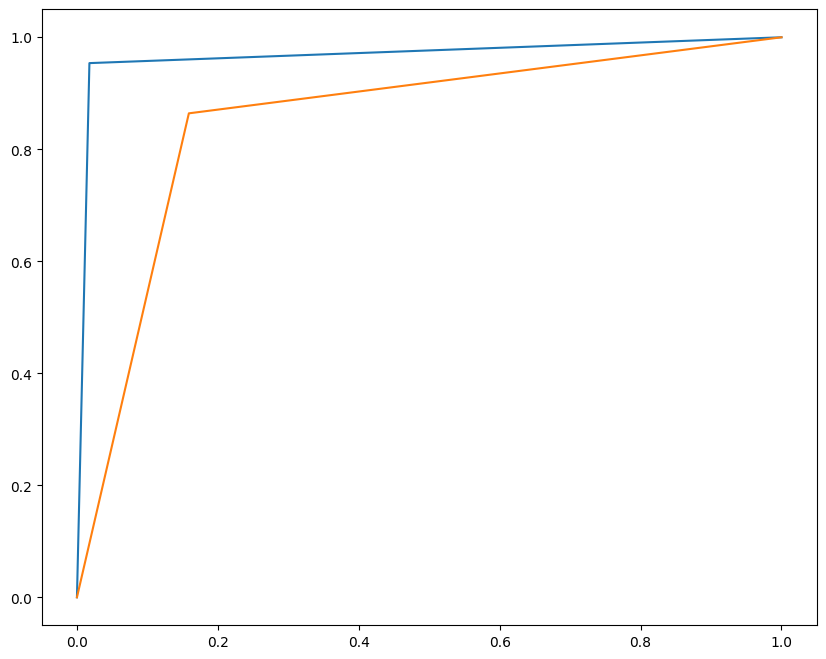

In [226]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plotting ROC for each model
plt.figure(figsize=(10, 8))

# Model 1
fpr1, tpr1, _ = roc_curve(y_val, y_hat_XGB_val)
roc_auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, label=f'XGBC (AUC = {roc_auc1:.2f})')

# Model 2
fpr2, tpr2, _ = roc_curve(y_val, y_hat_LR_val)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label=f'LOGR (AUC = {roc_auc2:.2f})')

# Model 3
fpr3, tpr3, _ = roc_curve(y_val, y_hat_XGB2_val)
roc_auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, label=f'META_XGBC (AUC = {roc_auc3:.2f})')

# Plot details
plt.plot([0, 1], [0, 1], 'k--', label='Chance')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Three Models')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [258]:
# Make predictions using the best model directly on test_data
y_hat_XGB_test = xgb.predict(test_set)

# Prepare the output DataFrame
output = pd.DataFrame({'id': test_id, 'loan_status': y_hat_XGB_test})

# Remove any duplicate rows by 'PassengerId'
output.drop_duplicates(subset='id', keep='first', inplace=True)

# Save predictions to a CSV file
output.to_csv('predictions.csv', index=False)
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>